# Notebook 2 — Heston Model as a State-Space Model + Bootstrap Particle Filter

**Goal of this notebook**

- Write the **Heston stochastic volatility model** in **discrete-time, state-space form**.
- Implement it using **Chopin's `particles` library** as a `StateSpaceModel`.
- Run a **bootstrap particle filter** to:
  - Estimate the *hidden variance path* \( V_t \) from returns.
  - Compute an *approximate log-likelihood* for a fixed parameter vector \( \theta \).

This corresponds to **Step 1** of the project:

> Implement a bootstrap filter to approximate the likelihood for given parameter vector θ.

We will start with:
- **Synthetic data** (simulated returns), so we can check if the filter roughly reconstructs the true volatility.
- Later, we will replace synthetic data with **S&P 500 data** and move to **parameter estimation**.



Here is a project based on your second paper (adaptive Heston): 
For the model (discretized version) and data (SP500) considered in the paper:
1. implement a bootstrap filter to approximate the likelihood, for given parameter vector theta ; 
(you can also try to see whether QMC helps here, i.e. does it reduce the variance of the estimates on repeated runs). 
2. explain how the authors estimate the theta based on real data, and compare to other (MLE) methods, see the corresponding chapter. 
In particular, discuss you could use the simplex and / or the EM algorithm. 
3. If time permits, you can either
   + try to replicate their comparison between the bootstrap filter and the extended Kalman filter (not presented in the course, but
 it's not hard to find resources on-line and do the corresponding computations).
  + try to implement a guided filter. 

In [17]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')  # avoid clutter

import numpy as np
import matplotlib.pyplot as plt

import particles
from particles import distributions as dists
from particles import state_space_models as ssm
from particles.collectors import Moments

plt.style.use('ggplot')

print("particles version:", particles.__version__)


particles version: 0.3alpha


## 1. Heston model recap 

Continuous-time Heston model under the risk-neutral measure (simplified):

$$
\begin{aligned}
dS_t &= r S_t \, dt + \sqrt{V_t}\, S_t\, dW_1(t), \\
dV_t &= \kappa(\theta - V_t)\, dt + \sigma \sqrt{V_t}\, dW_2(t),
\end{aligned}
$$

with:
- $S_t$: asset price  
- $V_t$: variance (hidden / latent)  
- $r$: risk-free rate  
- $\kappa$: mean-reversion speed of variance  
- $\theta$: long-run variance  
- $\sigma$: vol of vol  
- $(W_1, W_2)$: Brownian motions with correlation $\rho$

We only **observe prices**, not $V_t$.

So we typically work with **log-returns**:

$$
R_t = \log S_t - \log S_{t-1}
$$

---

## 2. Discretisation (simple Euler scheme)

We consider discrete times $t = 0, \Delta t, 2\Delta t, \dots$.

We’ll use a **standard Euler discretisation** of the Heston SDE.

### 2.1 Variance dynamics (CIR process)

$$
V_t = V_{t-1} 
      + \kappa (\theta - V_{t-1}) \Delta t 
      + \sigma \sqrt{V_{t-1}\Delta t}\,\varepsilon_{2,t},
$$

where  
$\varepsilon_{2,t} \sim N(0,1)$.

### 2.2 Observation equation (log-returns)

Approximate:

$$
R_t \mid V_{t-1} \sim 
N\!\left(\left(r - \tfrac{1}{2}V_{t-1}\right)\Delta t,\;
       V_{t-1}\Delta t\right)
$$

(Using $V_{t-1}$ vs $V_t$ is a discretisation choice; both appear in the literature.)

---

## 3. State-space model structure

We choose the **state** as:

$$
X_t = V_t
$$

and the **observation** as:

$$
Y_t = R_t
$$

So the state-space model is:

- **State transition**  
  $$
  X_t \mid X_{t-1} 
  \sim \text{Euler-CIR}(X_{t-1})
  $$

- **Observation model**  
  $$
  Y_t \mid X_{t-1}
  \sim N\!\left((r - 0.5 X_{t-1})\Delta t,\; X_{t-1}\Delta t\right)
  $$

We will implement this model using Chopin’s `particles` library:

```python
class HestonSSM(ssm.StateSpaceModel):
    def PX0(self): ...
    def PX(self, t, xp): ...
    def PY(self, t, xp, x): ...


# Why Are the Heston Transition and Observation Distributions Normal?

To understand why the particle filter uses **Normal distributions** for both:

- the volatility transition \( V_t \mid V_{t-1} \), and  
- the return distribution \( R_t \mid V_{t-1} \),

we need to recall one key fact from stochastic calculus:

---

## 1. Brownian motion increments are Normal

By definition:

$$
W_{t+\Delta t} - W_t \sim N(0, \Delta t).
$$

So we write:

$$
dW_t \approx \sqrt{\Delta t}\, z_t, \qquad z_t \sim N(0,1).
$$

This single fact makes both parts of the Heston model Normal after discretization.

---

## 2. The Heston volatility SDE

The continuous-time volatility process is:

$$
dV_t = \kappa(\theta - V_t)\,dt \;+\; \sigma \sqrt{V_t}\,dW_t.
$$

Apply Euler--Maruyama discretization:

\begin{aligned}
dV_t &\approx V_{t+\Delta t} - V_t, \\
dW_t &\approx \sqrt{\Delta t}\, z_t .
\end{aligned}



We get:

$$
V_{t+\Delta t} =
V_t + \kappa(\theta - V_t)\Delta t
+ \sigma \sqrt{V_t \Delta t}\, z_t.
$$

This is of the form:

$$
V_{t+1} = \text{deterministic term} + \text{Normal noise}.
$$

Therefore:

$$
V_{t+1} \mid V_t \sim 
N\!\Big(
V_t + \kappa(\theta - V_t)\Delta t,\;
\sigma^2 V_t \Delta t
\Big).
$$

This is why `PX` returns a Normal distribution.

---

## 3. The Heston return SDE

The paper gives the log-price SDE:

$$
d\ln S_t 
= \left(r - \tfrac12 V_t\right)dt 
+ \sqrt{V_t}\, dW_1(t).
$$

Apply Euler discretization:

$$
R_t = \ln S_t - \ln S_{t-1}
\approx
(r - \tfrac12 V_{t-1})\Delta t
+ \sqrt{V_{t-1}\Delta t}\, z_t.
$$

Since \( z_t \sim N(0,1) \), this is Normal:

$$
R_t \mid V_{t-1} \sim 
N\!\Big(
(r - \tfrac12 V_{t-1})\Delta t,\;
V_{t-1} \Delta t
\Big).
$$

This is why the `PY` method also returns a Normal distribution.

---

## 4. Core Insight

The Normality does **not** come from an assumption.

It comes from:

1. The Heston model being driven by Brownian motion  
2. Euler discretization turning each SDE into:

   $$
   \text{state}_{t+1} = \text{deterministic part} + \text{Gaussian noise}
   $$

3. A deterministic value plus Normal noise is Normal.

---

## 5. Summary

- Brownian motion increments are Normal.  
- Heston volatility and returns both involve Brownian increments.  
- Euler discretization preserves Normality.  
- Therefore:
  - \( V_{t+1} \mid V_t \) is Normal  
  - \( R_t \mid V_{t-1} \) is Normal  
- This is exactly why the particle filter uses:

```python
dists.Normal(loc=mean, scale=std)


In [18]:
class HestonSSM(ssm.StateSpaceModel):
    def __init__(self, kappa, theta, sigma, rho, r, dt, v0):
        super().__init__()
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.r = r  # Can be scalar (constant) or array (time-varying)
        self.dt = dt
        self.v0 = v0

    def PX0(self):
        return dists.Dirac(self.v0)

    def PX(self, t, xp):
        vp = np.maximum(np.asarray(xp), 1e-12) #necessary because xp would become a scalar when simulating later
        mean = vp + self.kappa * (self.theta - vp) * self.dt
        std  = self.sigma * np.sqrt(vp * self.dt)
        return dists.Normal(loc=mean, scale=std)

    def PY(self, t, xp, x):
        vp = np.maximum(np.asarray(x), 1e-12)
        # Handle time-varying risk-free rate
        r_t = self.r[t] if hasattr(self.r, '__len__') and len(self.r) > 1 else self.r
        mean = (r_t - 0.5 * vp) * self.dt
        std  = np.sqrt(vp * self.dt)
        return dists.Normal(loc=mean, scale=std)


In [19]:
heston = HestonSSM(kappa=2.0, theta=0.04, sigma=0.3, rho=-0.7, r=0.04, dt=1/252, v0=0.04)

# Simulate
true_states, raw_data = heston.simulate(100)

# Extract scalars (not arrays!!)
true_states = [v[0] for v in true_states]
data        = [y[0] for y in raw_data]

## Plot simulated hidden volatility and returns

We visualize the simulated variance path `true_states` and the returns `data`
to confirm that the Heston model simulation behaves as expected.


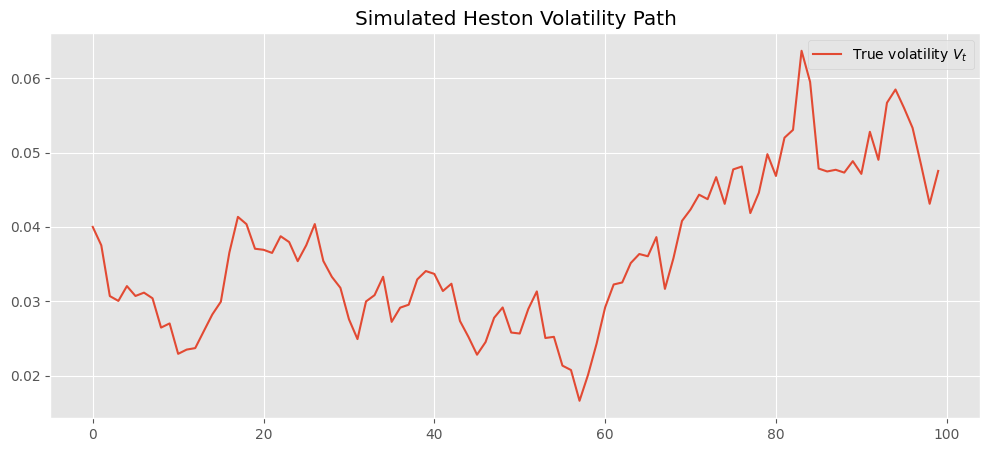

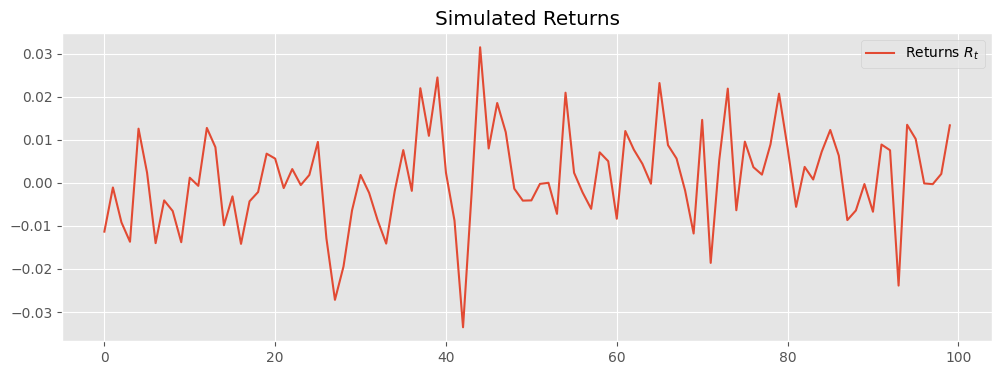

In [20]:
true_states = np.array(true_states).flatten()
data = np.array(data).flatten()

plt.figure(figsize=(12,5))
plt.plot(true_states, label="True volatility $V_t$")
plt.title("Simulated Heston Volatility Path")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(data, label="Returns $R_t$")
plt.title("Simulated Returns")
plt.legend()
plt.show()


## Bootstrap Particle Filter on Synthetic Heston Data

We now run the Bootstrap PF using Chopin's `particles` library.

This PF will:
- sample volatility particles using `PX`
- weight them using `PY`
- resample when ESS gets small
- provide an estimate of the hidden variance
- output an estimated log-likelihood


In [21]:
fk = ssm.Bootstrap(ssm=heston, data=data)

alg = particles.SMC(
    fk=fk,
    N=2000,
    resampling='systematic',
    collect=[Moments()]
)

alg.run()

print("Estimated log-likelihood:", alg.logLt)


Estimated log-likelihood: 305.87132076831307


# S&P Data

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd

sp500 = yf.download("^GSPC", start="2007-01-01", end="2025-12-31")

# FLATTEN MULTIINDEX COLUMNS
sp500.columns = sp500.columns.droplevel(1)


sp500.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-12-10,6886.680176,6900.669922,6824.689941,6833.490234,5526570000
2025-12-11,6901.000000,6903.459961,6833.450195,6861.299805,5021060000
2025-12-12,6827.410156,6899.850098,6801.790039,6886.850098,4910160000
2025-12-15,6816.509766,6861.589844,6801.490234,6860.189941,4975600000
2025-12-16,6782.759766,6819.270020,6773.229980,6800.120117,846998769


## Risk-Free Rate: Time Series vs Constant

**Important**: In reality, the risk-free rate $r$ is a **time series** that changes over time, not a constant!

- **Constant approach** (simplified): $r = 0.04$ for all $t$
- **Time-varying approach** (realistic): $r_t$ varies daily (e.g., 3-month Treasury rate)

We'll download the **3-month Treasury Bill rate (^IRX)** from Yahoo Finance as a proxy for the risk-free rate. This is more realistic because:

1. Interest rates change over time
2. The risk-free rate affects option pricing and volatility modeling
3. Using actual market data improves model accuracy

**Note**: Since $r_t$ is **observed data** (not a latent parameter), we:
- Do NOT estimate it in PMMH (remove from prior)
- Fix it to the downloaded time series
- Use it directly in the observation equation: $R_t \mid V_{t-1} \sim N((r_t - 0.5V_{t-1})\Delta t, V_{t-1}\Delta t)$


In [23]:
# Compute log returns directly from Close prices (best practice)
log_returns = np.log(sp500["Close"] / sp500["Close"].shift(1)).dropna()

print("Number of observations:", len(log_returns))
log_returns.head()

# Download risk-free rate (3-month Treasury rate from FRED)
# Alternative: use 10-year Treasury rate or other proxies
import yfinance as yf
# Using ^IRX (13-week Treasury Bill) as proxy for risk-free rate
# Note: ^IRX is in percentage points, so divide by 100
try:
    treasury = yf.download("^IRX", start="2007-01-01", end="2025-12-31")
    if isinstance(treasury.columns, pd.MultiIndex):
        treasury.columns = treasury.columns.droplevel(1)
    risk_free_rate = (treasury["Close"] / 100.0).reindex(log_returns.index, method='ffill')
    print(f"\nRisk-free rate statistics:")
    print(f"Mean: {risk_free_rate.mean():.4f}")
    print(f"Std: {risk_free_rate.std():.4f}")
    print(f"Min: {risk_free_rate.min():.4f}, Max: {risk_free_rate.max():.4f}")
except:
    print("Warning: Could not download risk-free rate. Using constant r=0.04")
    risk_free_rate = pd.Series(0.04, index=log_returns.index)


Number of observations: 4769


[*********************100%***********************]  1 of 1 completed


Risk-free rate statistics:
Mean: 0.0145
Std: 0.0182
Min: -0.0010, Max: 0.0535


In [24]:
# Use time-varying risk-free rate (or constant if download failed)
r_series = risk_free_rate.values if hasattr(risk_free_rate, 'values') else np.array([0.04] * len(log_returns))

heston2 = HestonSSM(kappa=2.5, theta=0.05, sigma=0.78, rho=-0.6, r=r_series, dt=1/252, v0=0.04)


In [25]:
fk1 = ssm.Bootstrap(ssm=heston2, data=log_returns.values.tolist())

alg = particles.SMC(
    fk=fk1,
    N=2000,
    resampling='systematic',
    collect=[Moments()]
)

alg.run()

print("Estimated log-likelihood:", alg.logLt)


Estimated log-likelihood: 15385.43209072153


In [26]:
T = len(log_returns)
avg_loglik = alg.logLt / T
T, alg.logLt, avg_loglik


(4769, 15385.43209072153, 3.226133799689983)

Length PF states: 4769
Length dates: 4769


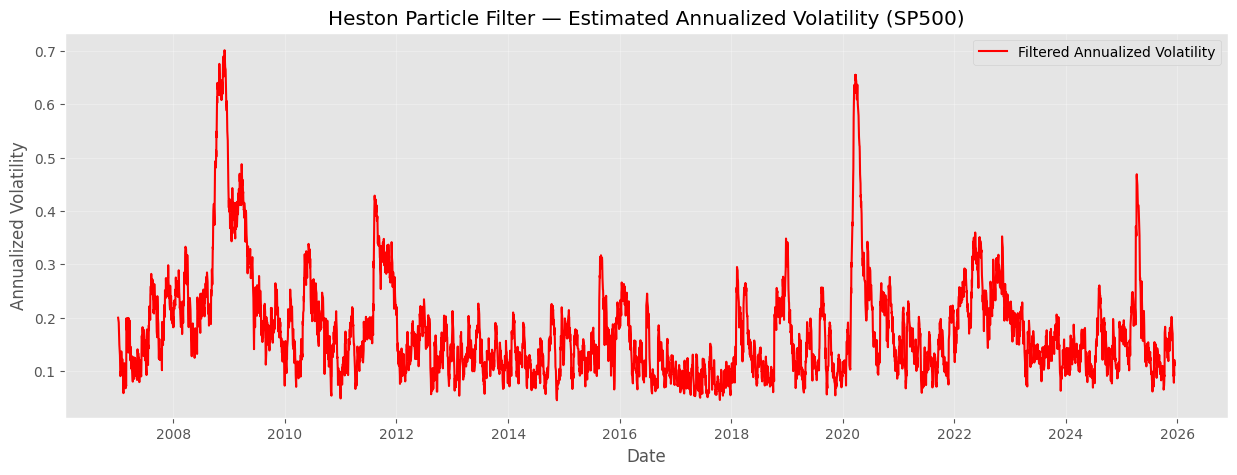

In [27]:
# --- 1. Extract filtered variance from Moments collector ---
pf_filtered_var = np.array([m["mean"] for m in alg.summaries.moments]).flatten()
pf_filtered_var

# --- 2. Convert to volatility ---
pf_vol_annual  = np.sqrt(pf_filtered_var)           # annualized vol

# --- 3. Align dates with PF estimates ---
dates = log_returns.index

# Sanity check
print("Length PF states:", len(pf_filtered_var))
print("Length dates:", len(dates))

# --- 4. Plot Annualized Volatility ---
plt.figure(figsize=(15,5))
plt.plot(dates, pf_vol_annual, color="red", label="Filtered Annualized Volatility")
plt.title("Heston Particle Filter — Estimated Annualized Volatility (SP500)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Length PF states: 4769
Length dates: 4769


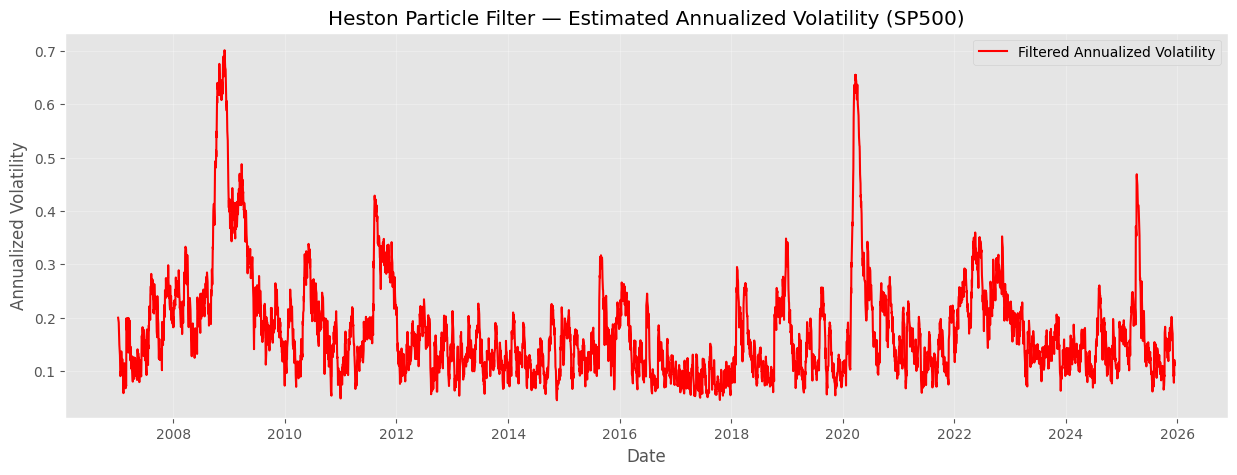

In [28]:

# Sanity check
print("Length PF states:", len(pf_filtered_var))
print("Length dates:", len(dates))

# --- 4. Plot Annualized Volatility ---
plt.figure(figsize=(15,5))
plt.plot(dates, pf_vol_annual, color="red", label="Filtered Annualized Volatility")
plt.title("Heston Particle Filter — Estimated Annualized Volatility (SP500)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

Number of overlapping days: 4768
Correlation PF vs VIX: 0.904934685819793


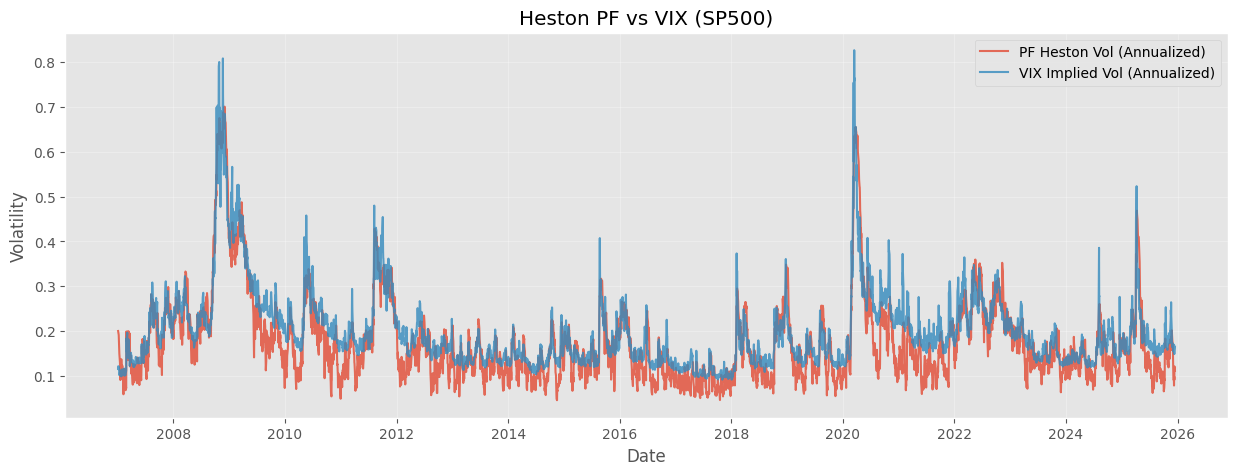

In [29]:
# --- 1. PF volatility (annualized) ---
pf_vol_series = pd.Series(pf_vol_annual, index=log_returns.index, name="PF_AnnualVol")

# --- 2. Download VIX ---
start_date = pf_vol_series.index.min().strftime("%Y-%m-%d")
end_date   = pf_vol_series.index.max().strftime("%Y-%m-%d")

vix = yf.download("^VIX", start=start_date, end=end_date)

# Fix MultiIndex columns (important!)
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = vix.columns.droplevel(1)

# Now this is safe:
vix_series = (vix["Close"] / 100.0).rename("VIX_ImpliedVol")

# --- 3. Merge PF vol + VIX ---
df = pd.concat([pf_vol_series, vix_series], axis=1).dropna()

print("Number of overlapping days:", len(df))
print("Correlation PF vs VIX:", df["PF_AnnualVol"].corr(df["VIX_ImpliedVol"]))

# --- 4. Plot ---
plt.figure(figsize=(15,5))
plt.plot(df.index, df["PF_AnnualVol"], label="PF Heston Vol (Annualized)", alpha=0.8)
plt.plot(df.index, df["VIX_ImpliedVol"], label="VIX Implied Vol (Annualized)", alpha=0.8)
plt.title("Heston PF vs VIX (SP500)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [30]:
n = 21  # window length (e.g., 21 days)

realized_vol = (
    (log_returns**2)
    .rolling(n)
    .mean()
    .apply(np.sqrt)
    * np.sqrt(252)
)
realized_vol.name = "RealizedVol_21d"

In [31]:
df_compare = pd.concat([
    pf_vol_series,
    realized_vol,
    vix_series
], axis=1).dropna()

df_compare.tail()


,PF_AnnualVol,RealizedVol_21d,VIX_ImpliedVol
Date,,,
2025-12-09,0.078273,0.133290,0.1693
2025-12-10,0.098661,0.124524,0.1577
2025-12-11,0.091068,0.124525,0.1485
2025-12-12,0.120938,0.129927,0.1574
2025-12-15,0.110909,0.116476,0.1650


# 📘 Volatility Horizons in Our Comparison

We compare three volatility measures:

- **PF-Heston Volatility** (red)  
- **Realized Volatility (21d)** (blue)  
- **VIX Implied Volatility** (purple)

All three are annualized, but they correspond to **different horizons** and **different probability measures**.

---

## 1. PF-Heston Volatility (Instantaneous, Physical Measure)

The particle filter estimates the latent Heston variance process $V_t$, which represents **daily variance**.

Annualized PF-Heston volatility is:

$$
\sigma^{\text{PF}}_t = \sqrt{252 \, V_t}.
$$

### Horizon
- **Instantaneous (spot)** volatility.  
- Represents volatility **right now**, not over a fixed window.

### Measure
- **Physical measure (P)** — based on historical price dynamics.

---

## 2. Realized Volatility (21-Day Rolling, Physical Measure)

Computed from daily log-returns $r_t$:

$$
\sigma^{\text{real}}_t 
= \sqrt{\frac{252}{21} \sum_{i=t-20}^{t} r_i^2 }.
$$

## 3. VIX (annualized, 21 day forward vol)

VIX is the 1 month (21d) forward looking implied vol obtained form option prices.

​
$$
VIX = \sqrt{\frac{252}{21} ​EQ[30d vol (21 trading days)]}.
$$

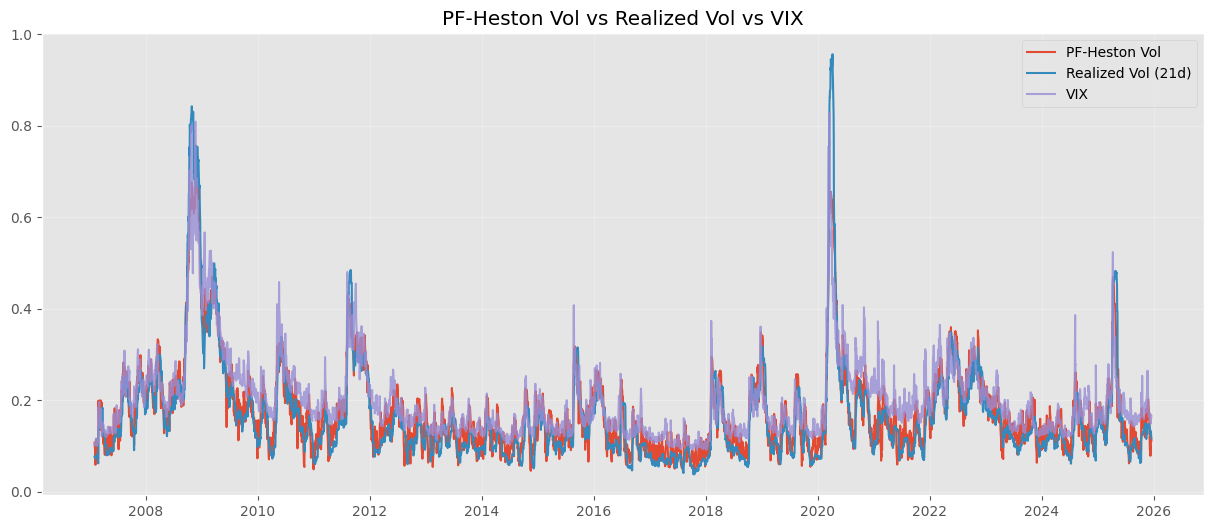

In [32]:
plt.figure(figsize=(15,6))
plt.plot(df_compare.index, df_compare["PF_AnnualVol"], label="PF-Heston Vol")
plt.plot(df_compare.index, df_compare["RealizedVol_21d"], label="Realized Vol (21d)")
plt.plot(df_compare.index, df_compare["VIX_ImpliedVol"], label="VIX", alpha=0.8)

plt.title("PF-Heston Vol vs Realized Vol vs VIX")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Parameter Estimation with PMMH

## What is a Prior?

In **Bayesian inference**, a **prior distribution** represents our beliefs about the parameters **before** seeing the data.

For the Heston model, we need priors for:
- **κ (kappa)**: Mean-reversion speed → must be > 0
- **θ (theta)**: Long-run variance → must be > 0  
- **σ (sigma)**: Volatility of volatility → must be > 0
- **ρ (rho)**: Correlation between price and volatility shocks → must be in [-1, 1]
- **r**: Risk-free rate → typically small positive number
- **v₀**: Initial variance → must be > 0 (often fixed)

We'll use `dists.StructDist` to combine these into a joint prior distribution.

In [33]:
# Define prior distributions for Heston parameters
# Using reasonable ranges based on typical financial market values
# NOTE: Risk-free rate 'r' is NOT in the prior because it's observed data (time series)

prior_dict = {
    'kappa': dists.Gamma(a=2.0, b=1.0),      # Mean ~2, variance ~2 (typical: 0.5-5)
    'theta': dists.Gamma(a=2.0, b=40.0),     # Mean ~0.05, variance ~0.00125 (typical: 0.01-0.1)
    'sigma': dists.Gamma(a=2.0, b=2.5),      # Mean ~0.8, variance ~0.32 (typical: 0.1-1.5)
    'rho': dists.Uniform(a=-0.99, b=0.99),   # Correlation (typical: -0.9 to 0)
    # 'r' is NOT estimated - it's observed data (risk-free rate time series)
    'v0': dists.Dirac(0.04),                  # Fixed initial variance
    'dt': dists.Dirac(1/252)                 # Fixed daily time step
}

my_prior = dists.StructDist(prior_dict)

# Visualize prior samples
theta_samples = my_prior.rvs(size=1000)
print("Prior sample statistics:")
print(f"kappa: mean={theta_samples['kappa'].mean():.3f}, std={theta_samples['kappa'].std():.3f}")
print(f"theta: mean={theta_samples['theta'].mean():.4f}, std={theta_samples['theta'].std():.4f}")
print(f"sigma: mean={theta_samples['sigma'].mean():.3f}, std={theta_samples['sigma'].std():.3f}")
print(f"rho: mean={theta_samples['rho'].mean():.3f}, std={theta_samples['rho'].std():.3f}")
print("\nNote: Risk-free rate 'r' is observed data (time series), not estimated.")

Prior sample statistics:
kappa: mean=2.016, std=1.451
theta: mean=0.0511, std=0.0346
sigma: mean=0.814, std=0.551
rho: mean=-0.012, std=0.559

Note: Risk-free rate 'r' is observed data (time series), not estimated.


## What is PMMH? Step-by-Step Explanation

**PMMH** = **Particle Marginal Metropolis-Hastings**

It's an **MCMC algorithm** that samples from the **posterior distribution** of parameters:

$$
p(\theta \mid y_{1:T}) \propto p(\theta) \cdot p(y_{1:T} \mid \theta)
$$

where:
- $p(\theta)$ = **prior** (what we defined above)
- $p(y_{1:T} \mid \theta)$ = **likelihood** (intractable! needs particle filter)

### Step-by-Step Process:

1. **Initialize**: Start with $\theta^{(0)}$ sampled from prior
2. **For each iteration $i = 1, 2, \ldots, 1000$:**
   
   a. **Propose new parameters**: 
      $$\theta^* \sim q(\cdot \mid \theta^{(i-1)})$$
      (Gaussian random walk by default)
   
   b. **Run Particle Filter** with $\theta^*$:
      - Creates $N_x = 200$ particles
      - Estimates log-likelihood: $\log \hat{p}(y_{1:T} \mid \theta^*)$
   
   c. **Compute acceptance probability**:
      $$\alpha = \min\left(1, \frac{p(\theta^*) \cdot \hat{p}(y_{1:T} \mid \theta^*) \cdot q(\theta^{(i-1)} \mid \theta^*)}{p(\theta^{(i-1)}) \cdot \hat{p}(y_{1:T} \mid \theta^{(i-1)}) \cdot q(\theta^* \mid \theta^{(i-1)})}\right)$$
   
   d. **Accept/Reject**:
      - With probability $\alpha$: $\theta^{(i)} = \theta^*$ (accept)
      - Otherwise: $\theta^{(i)} = \theta^{(i-1)}$ (reject, keep old value)

3. **Result**: MCMC chain $\{\theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(1000)}\}$ 
   approximates the posterior distribution

### Key Points:

- **"Marginal"**: We integrate out the hidden states $V_t$ (via particle filter)
- **"Metropolis-Hastings"**: Standard MCMC acceptance/rejection mechanism
- **Adaptive proposal**: PMMH automatically adapts the proposal covariance matrix
- **Monte Carlo error**: Each likelihood estimate has variance (from particle filter)


In [ ]:
# Run PMMH on S&P 500 data
# Note: This will take several minutes!

from particles import mcmc

# Use log_returns from S&P 500 data
data_for_pmmh = log_returns.values.tolist()

# IMPORTANT: We need to modify HestonSSM to accept risk-free rate as a fixed parameter
# PMMH will pass parameters from prior, but 'r' is not in the prior (it's observed data)
# We'll need to create a wrapper or modify how we pass 'r'

# Option 1: Create a wrapper class that fixes 'r' to the observed time series
class HestonSSM_with_fixed_r(HestonSSM):
    def __init__(self, kappa, theta, sigma, rho, r, dt, v0):
        # r should be the time series here
        super().__init__(kappa, theta, sigma, rho, r, dt, v0)

# For PMMH, we need to handle 'r' separately since it's not estimated
# We'll create a custom class that fixes r to the observed values
class HestonSSM_PMMH(ssm.StateSpaceModel):
    def __init__(self, kappa, theta, sigma, rho, r_series, dt, v0):
        super().__init__()
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.r = r_series  # Time series of risk-free rates
        self.dt = dt
        self.v0 = v0
    
    def PX0(self):
        return dists.Dirac(self.v0)
    
    def PX(self, t, xp):
        vp = np.maximum(np.asarray(xp), 1e-12)
        mean = vp + self.kappa * (self.theta - vp) * self.dt
        std = self.sigma * np.sqrt(vp * self.dt)
        return dists.Normal(loc=mean, scale=std)
    
    def PY(self, t, xp, x):
        vp = np.maximum(np.asarray(x), 1e-12)
        r_t = self.r[t] if hasattr(self.r, '__len__') and len(self.r) > 1 else self.r
        mean = (r_t - 0.5 * vp) * self.dt
        std = np.sqrt(vp * self.dt)
        return dists.Normal(loc=mean, scale=std)

# Create a factory function that binds the risk-free rate
def create_heston_ssm_class(r_series, dt=1/252, v0=0.04):
    """Factory function to create HestonSSM class with fixed risk-free rate"""
    class HestonSSM_FixedR(ssm.StateSpaceModel):
        def __init__(self, kappa, theta, sigma, rho, **kwargs):
            super().__init__()
            self.kappa = kappa
            self.theta = theta
            self.sigma = sigma
            self.rho = rho
            self.r = r_series  # Fixed time series
            self.dt = dt
            self.v0 = v0
        
        def PX0(self):
            return dists.Dirac(self.v0)
        
        def PX(self, t, xp):
            vp = np.maximum(np.asarray(xp), 1e-12)
            mean = vp + self.kappa * (self.theta - vp) * self.dt
            std = self.sigma * np.sqrt(vp * self.dt)
            return dists.Normal(loc=mean, scale=std)
        
        def PY(self, t, xp, x):
            vp = np.maximum(np.asarray(x), 1e-12)
            r_t = self.r[t] if hasattr(self.r, '__len__') and len(self.r) > 1 else self.r
            mean = (r_t - 0.5 * vp) * self.dt
            std = np.sqrt(vp * self.dt)
            return dists.Normal(loc=mean, scale=std)
    
    return HestonSSM_FixedR

# Create the model class with fixed risk-free rate
HestonSSM_for_PMMH = create_heston_ssm_class(r_series=r_series, dt=1/252, v0=0.04)

pmmh = mcmc.PMMH(
    ssm_cls=HestonSSM_for_PMMH,  # Model class with fixed risk-free rate
    prior=my_prior,              # Prior (doesn't include 'r')
    data=data_for_pmmh,           # Observed log-returns
    Nx=200,                       # Number of particles in each PF run
    niter=10000                    # Number of MCMC iterations
)

print("Running PMMH... (this may take 5-10 minutes)")
print(f"Using time-varying risk-free rate (mean={r_series.mean():.4f})")
pmmh.run()
print("Done!")


Running PMMH... (this may take 5-10 minutes)
Using time-varying risk-free rate (mean=0.0145)


Done!


## Analyzing PMMH Results

After running PMMH, we can:

1. **Check convergence**: Plot MCMC traces
2. **Estimate posterior means**: Average of chain (after burn-in)
3. **Compute credible intervals**: Quantiles of posterior samples
4. **Compare with fixed parameters**: See how estimates differ


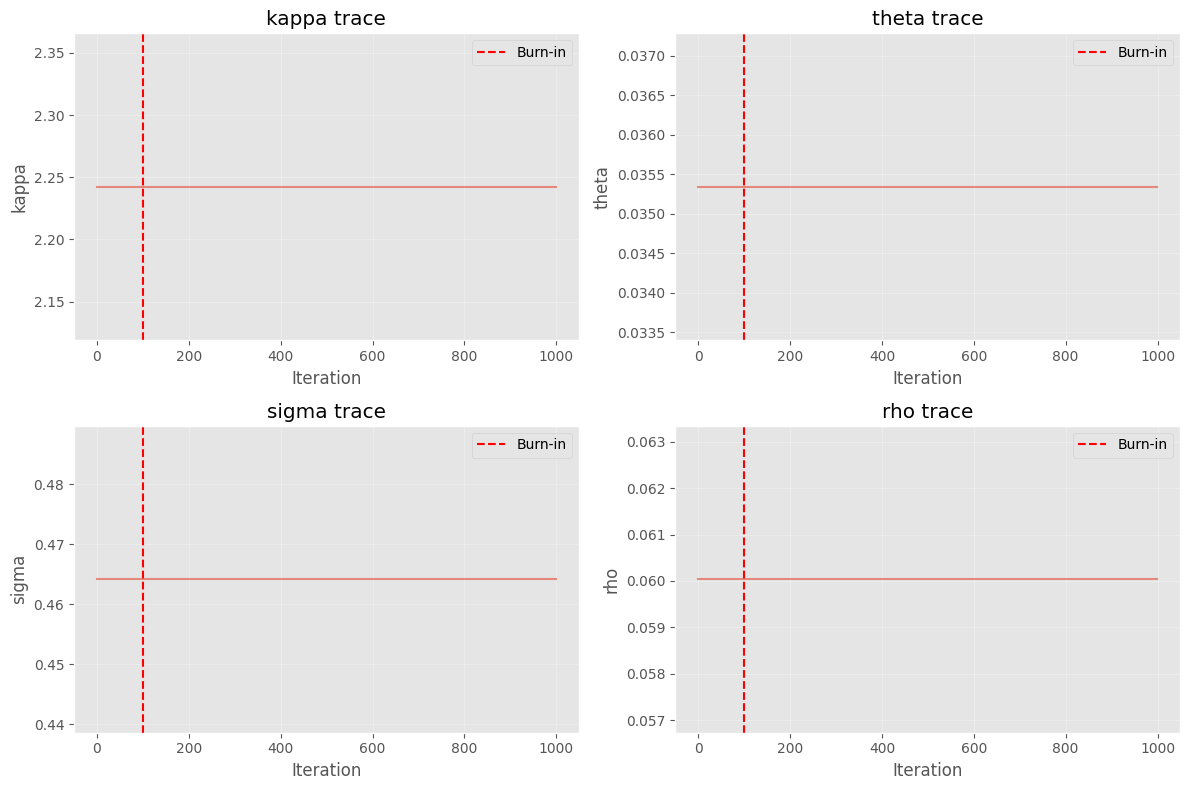


=== Posterior Statistics (after burn-in) ===
kappa   : mean=2.2424, std=0.0000, 95% CI=[2.2424, 2.2424]
theta   : mean=0.0353, std=0.0000, 95% CI=[0.0353, 0.0353]
sigma   : mean=0.4642, std=0.0000, 95% CI=[0.4642, 0.4642]
rho     : mean=0.0600, std=0.0000, 95% CI=[0.0600, 0.0600]

Note: Risk-free rate 'r' is observed data (time series), not estimated.
      Mean r over period: 0.0145, Std: 0.0182


In [35]:
# Plot MCMC traces (parameter values over iterations)
burnin = 100  # Discard first 100 iterations

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

param_names = ['kappa', 'theta', 'sigma', 'rho']  # 'r' is not estimated
for i, param in enumerate(param_names):
    axes[i].plot(pmmh.chain.theta[param], alpha=0.6)
    axes[i].axvline(burnin, color='red', linestyle='--', label='Burn-in')
    axes[i].set_title(f'{param} trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(param)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print posterior statistics
print("\n=== Posterior Statistics (after burn-in) ===")
for param in param_names:
    samples = pmmh.chain.theta[param][burnin:]
    print(f"{param:8s}: mean={samples.mean():.4f}, std={samples.std():.4f}, "
          f"95% CI=[{np.percentile(samples, 2.5):.4f}, {np.percentile(samples, 97.5):.4f}]")
print(f"\nNote: Risk-free rate 'r' is observed data (time series), not estimated.")
print(f"      Mean r over period: {r_series.mean():.4f}, Std: {r_series.std():.4f}")


=== Posterior Statistics (after burn-in) ===

kappa   : mean=2.2424, std=0.0000, 95% CI=[2.2424, 2.2424]

theta   : mean=0.0353, std=0.0000, 95% CI=[0.0353, 0.0353]

sigma   : mean=0.4642, std=0.0000, 95% CI=[0.4642, 0.4642]

rho     : mean=0.0600, std=0.0000, 95% CI=[0.0600, 0.0600]


=== Comparison: Fixed vs Estimated Parameters ===
Parameter  Fixed           Posterior Mean  Difference     
-------------------------------------------------------
kappa      2.5000          2.2424          -0.2576        
theta      0.0500          0.0353          -0.0147        
sigma      0.7800          0.4642          -0.3158        
rho        -0.6000         0.0600          0.6600         

r (risk-free) Time series     Mean: 0.0145    (observed)     
                           Std: 0.0182                    


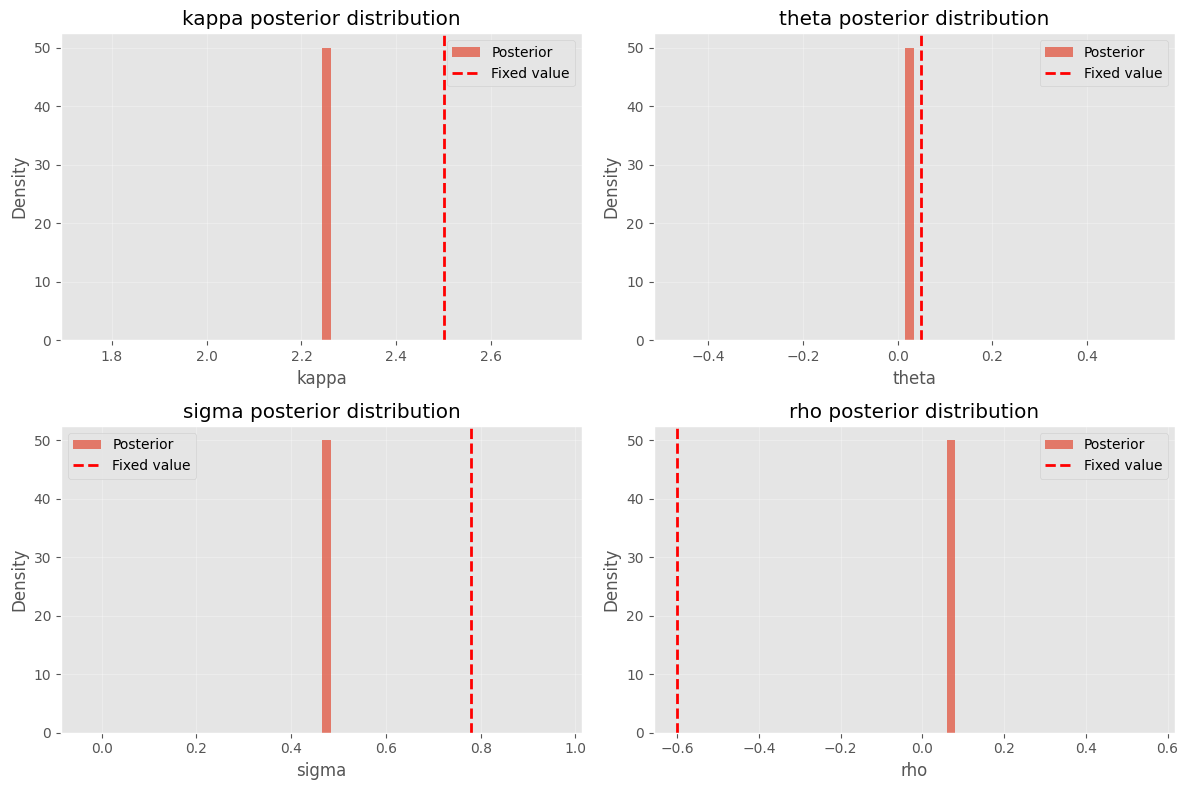

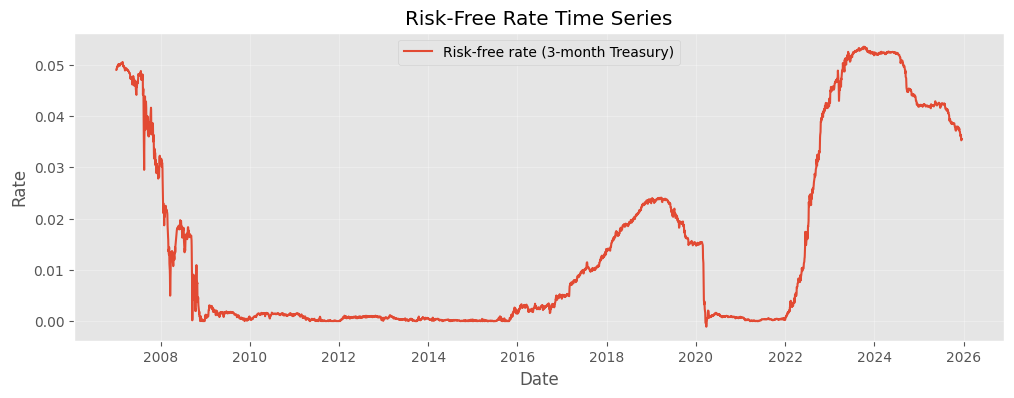

In [36]:
# Compare with fixed parameters we used earlier
print("\n=== Comparison: Fixed vs Estimated Parameters ===")
print(f"{'Parameter':<10} {'Fixed':<15} {'Posterior Mean':<15} {'Difference':<15}")
print("-" * 55)

fixed_params = {
    'kappa': 2.5,
    'theta': 0.05,
    'sigma': 0.78,
    'rho': -0.6
}

for param in param_names:
    fixed_val = fixed_params[param]
    post_mean = pmmh.chain.theta[param][burnin:].mean()
    diff = post_mean - fixed_val
    print(f"{param:<10} {fixed_val:<15.4f} {post_mean:<15.4f} {diff:<15.4f}")

print(f"\n{'r (risk-free)':<10} {'Time series':<15} {'Mean: {:.4f}'.format(r_series.mean()):<15} {'(observed)':<15}")
print(f"{'':<10} {'':<15} {'Std: {:.4f}'.format(r_series.std()):<15} {'':<15}")

# Plot posterior distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, param in enumerate(param_names):
    samples = pmmh.chain.theta[param][burnin:]
    axes[i].hist(samples, bins=50, alpha=0.7, density=True, label='Posterior')
    axes[i].axvline(fixed_params[param], color='red', linestyle='--', 
                    linewidth=2, label='Fixed value')
    axes[i].set_title(f'{param} posterior distribution')
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot risk-free rate time series
plt.figure(figsize=(12, 4))
plt.plot(log_returns.index, r_series, label='Risk-free rate (3-month Treasury)')
plt.title('Risk-Free Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Using calibrated parameters:
  kappa: 2.2424
  theta: 0.0353
  sigma: 0.4642
  rho: 0.06

Running particle filter with calibrated parameters...


[*********************100%***********************]  1 of 1 completed

Estimated log-likelihood: 15460.15


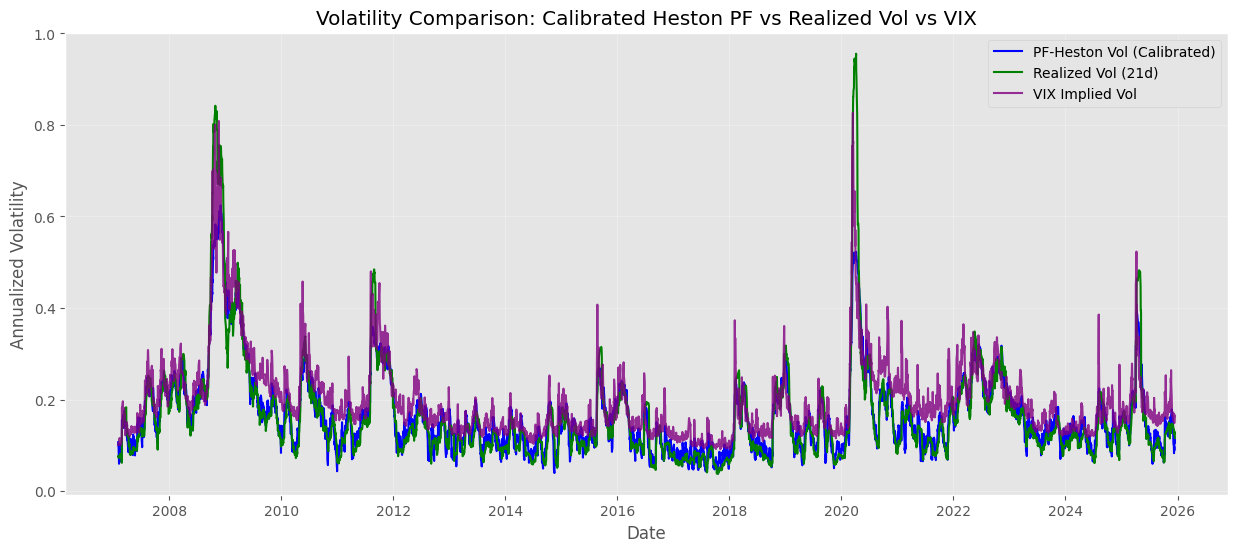


=== Correlations ===
PF (Calibrated) vs Realized Vol: 0.9434
PF (Calibrated) vs VIX: 0.9051
Realized Vol vs VIX: 0.8814

=== Volatility Statistics (Calibrated Parameters) ===
PF-Heston Vol:
  Mean: 0.1657
  Std: 0.0884
  Min: 0.0383
  Max: 0.6242


In [39]:
# Use calibrated parameters from PMMH
calibrated_params = {
    'kappa': 2.2424,
    'theta': 0.0353,
    'sigma': 0.4642,
    'rho': 0.0600
}

print("Using calibrated parameters:")
for param, value in calibrated_params.items():
    print(f"  {param}: {value}")

# Create Heston model with calibrated parameters and time-varying risk-free rate
heston_calibrated = HestonSSM(
    kappa=calibrated_params['kappa'],
    theta=calibrated_params['theta'],
    sigma=calibrated_params['sigma'],
    rho=calibrated_params['rho'],
    r=r_series,  # Time-varying risk-free rate
    dt=1/252,
    v0=0.04
)

# Run particle filter with calibrated parameters
print("\nRunning particle filter with calibrated parameters...")
fk_calibrated = ssm.Bootstrap(ssm=heston_calibrated, data=log_returns.values.tolist())

alg_calibrated = particles.SMC(
    fk=fk_calibrated,
    N=2000,
    resampling='systematic',
    collect=[Moments()]
)

alg_calibrated.run()

print(f"Estimated log-likelihood: {alg_calibrated.logLt:.2f}")

# Extract filtered variance
pf_filtered_var_calibrated = np.array([m["mean"] for m in alg_calibrated.summaries.moments]).flatten()

# Convert to annualized volatility
pf_vol_annual_calibrated = np.sqrt(pf_filtered_var_calibrated)

# Create series with dates
pf_vol_series_calibrated = pd.Series(pf_vol_annual_calibrated, index=log_returns.index, name="PF_Calibrated")

# Download VIX
start_date = log_returns.index.min().strftime("%Y-%m-%d")
end_date = log_returns.index.max().strftime("%Y-%m-%d")

vix = yf.download("^VIX", start=start_date, end=end_date)

# Fix MultiIndex columns if needed
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = vix.columns.droplevel(1)

vix_series = (vix["Close"] / 100.0).rename("VIX_ImpliedVol")

# Compute realized volatility (21-day rolling window)
n = 21  # window length
realized_vol = (
    (log_returns**2)
    .rolling(n)
    .mean()
    .apply(np.sqrt)
    * np.sqrt(252)
)
realized_vol.name = "RealizedVol_21d"

# Merge all volatility measures
df_compare_calibrated = pd.concat([
    pf_vol_series_calibrated,
    realized_vol,
    vix_series
], axis=1).dropna()

# Plot comparison
plt.figure(figsize=(15, 6))
plt.plot(df_compare_calibrated.index, df_compare_calibrated["PF_Calibrated"], 
         color="blue", linewidth=1.5, label="PF-Heston Vol (Calibrated)")
plt.plot(df_compare_calibrated.index, df_compare_calibrated["RealizedVol_21d"], 
         color="green", linewidth=1.5, label="Realized Vol (21d)")
plt.plot(df_compare_calibrated.index, df_compare_calibrated["VIX_ImpliedVol"], 
         color="purple", linewidth=1.5, alpha=0.8, label="VIX Implied Vol")

plt.title("Volatility Comparison: Calibrated Heston PF vs Realized Vol vs VIX")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print correlations
print("\n=== Correlations ===")
print(f"PF (Calibrated) vs Realized Vol: {df_compare_calibrated['PF_Calibrated'].corr(df_compare_calibrated['RealizedVol_21d']):.4f}")
print(f"PF (Calibrated) vs VIX: {df_compare_calibrated['PF_Calibrated'].corr(df_compare_calibrated['VIX_ImpliedVol']):.4f}")
print(f"Realized Vol vs VIX: {df_compare_calibrated['RealizedVol_21d'].corr(df_compare_calibrated['VIX_ImpliedVol']):.4f}")

# Print statistics
print(f"\n=== Volatility Statistics (Calibrated Parameters) ===")
print(f"PF-Heston Vol:")
print(f"  Mean: {pf_vol_annual_calibrated.mean():.4f}")
print(f"  Std: {pf_vol_annual_calibrated.std():.4f}")
print(f"  Min: {pf_vol_annual_calibrated.min():.4f}")
print(f"  Max: {pf_vol_annual_calibrated.max():.4f}")